In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import pyplot
import pickle


In [2]:
df = pd.read_csv("/Users/yad/Desktop/Project/data_prepared")


1. choose relevant columns


In [91]:
df_model= df[["Accomodation","Huawei","Level", "Maintenance-Time_h","Days_Taken","Type", "Description"]]


2. Get dummy columns


In [92]:
df_dummies= pd.get_dummies(df_model)

3.train-test split


In [93]:
from sklearn.model_selection import train_test_split
X= df_dummies.drop("Maintenance-Time_h", axis=1)
y= df["Maintenance-Time_h"].values

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state= 42)


4. Multiple linear regression

1. Statmodel(remove double hashtag to see summary on last line)

In [94]:

import statsmodels.api as sm
X_sm= X = sm.add_constant(X)
model = sm.OLS(y,X_sm)
##model.fit().summary()
# Adj R^2 = 0.86
# Some of the sugnificant variables (Level_Low,Type_Civil,Type_PPM,Type_RMS, etc..)
#bad Kurtosis value 26, cant claim normality 

2. Sklearn

In [95]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

Ln = LinearRegression()
Ln.fit(X_train, y_train)
np.mean(cross_val_score(Ln, X_train, y_train, scoring= "neg_mean_absolute_error", cv= 3))
# the regression model is off by a huge number, which tells us we probably have outliers and/or collinearity that makes the value of mean absolute error huge
# Since we seek performance, we dont need to remove collinearity, and further models that are not affected by collinearity is used down-below 

-8875428459324.387

In [96]:
from sklearn.metrics import mean_absolute_error
pred= Ln.predict(X_train)
mean_absolute_error(y_train, pred)
#since MAE is 0.243, which is a very reasonable number, it means it is correct that our data contained outliers because when the model had the chance 
#to learn from whole of x train, as done above, it gave out a resonable result 

0.2635856331168831

5. Lasso regression

In [97]:
Lm_l = Lasso()
np.mean(cross_val_score(Lm_l,X_train,y_train, scoring="neg_mean_absolute_error", cv= 3))
# lasso regression is off by 1.6747 hours on average
# since lasso regression is not affected by collinearity, we get a good result

-1.674782593361335

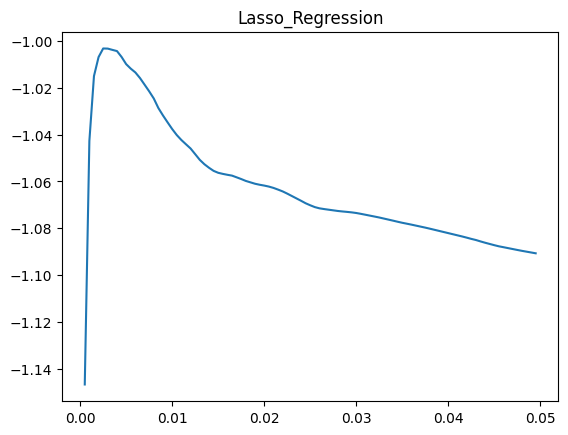

In [98]:
# Now lets try different alpha values 

alpha =[]
error =[]

for i in range(1,100):
    alpha.append(i/2000)
    lml= Lasso(alpha=(i/2000))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring="neg_mean_absolute_error",cv=3)))

Fig1 = plt.figure("Figure 1")
plt.plot(alpha,error);
plt.title("Lasso_Regression");
# used plot to find best alpha value visually first


In [99]:
err= tuple(zip(alpha, error))
df_e= pd.DataFrame(err, columns=["Alpha","error"])
df_e[df_e.error==max(df_e.error)]
# when alpha is 0.0025, the model is off by (1.00322) hours on average, which is an optimal alpha value that is used at the end of the report for producing predictions

,Alpha,error
4,0.0025,-1.00322


6. Ridge regression


In [100]:
from sklearn.linear_model import Ridge
Rg= Ridge(alpha=0.91)
np.mean(cross_val_score(Rg, X_train,y_train, scoring="neg_mean_absolute_error", cv=3))
# model is off by -0.99 hourse

-0.9919956510772144

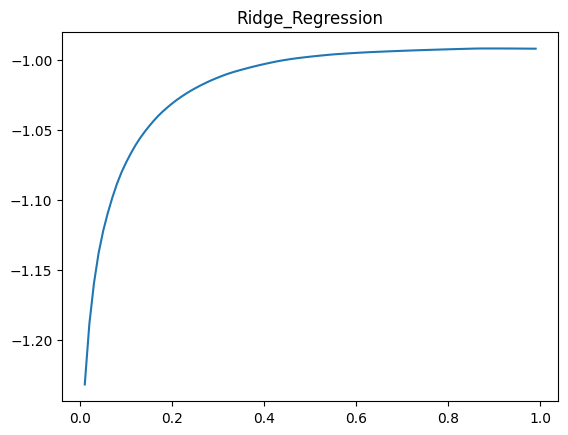

In [101]:
# Now lets try different alpha values 
alpha1 =[]
error1 =[]

for i in range(1,100):
    alpha1.append(i/100)
    lmR= Ridge(alpha=(i/100))
    error1.append(np.mean(cross_val_score(lmR,X_train,y_train, scoring="neg_mean_absolute_error",cv=3)))

Fig2 = plt.figure("Figure 2")
plt.plot(alpha1,error1);
plt.title("Ridge_Regression");
#used plotto find best alpha value visually first

In [102]:
err= tuple(zip(alpha1, error1))
df_e= pd.DataFrame(err, columns=["Alpha","error"])
print(df_e[df_e.error==max(df_e.error)])
#at alpha 0.91 we have the optimal alpha, however, no significant improvement on default alpha value.

    Alpha     error
90   0.91 -0.991996


7. Random-forest


In [103]:
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor()
np.mean(cross_val_score(rf, X_train,y_train, scoring='neg_mean_absolute_error', cv=3))
#the model is off predicting the maintenance time 0.9292592 hour

-0.9169532687359313

8. Tune Random_Forest using Gridsearch 


In [104]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':range(10,200,10), 'criterion':('absolute_error','squared_error'), 'max_features' :('sqrt', 'log2')}
GS= (GridSearchCV(RandomForestRegressor(random_state=42), parameters, scoring='neg_mean_absolute_error', cv=3))
GS.fit(X_train,y_train)


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ('absolute_error', 'squared_error'),
                         'max_features': ('sqrt', 'log2'),
                         'n_estimators': range(10, 200, 10)},
             scoring='neg_mean_absolute_error')

In [105]:
GS.best_score_

-0.877577376880985

In [106]:
GS.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_features='sqrt',
                      n_estimators=170, random_state=42)

In [107]:
Lpredict= Lasso(0.0025).fit(X_train,y_train).predict(X_test)
Rpredict= Ridge(alpha=0.91).fit(X_train,y_train).predict(X_test)
Rfpredict= GS.best_estimator_.predict(X_test)

print(mean_absolute_error(y_test, Lpredict))
print(mean_absolute_error(y_test, Rpredict)) 
print(mean_absolute_error(y_test, Rfpredict))

0.8436344129893758
0.9434352777393442
0.9208641600970285


In [108]:
print(mean_absolute_error(y_test, ((0.90 * Lpredict) + (0.1 * Rfpredict))))
#using combination of different models

0.8456672724787948


In [109]:
# At the end, our tuned Lasso regression predicted the best results (0.84363441)

Pickling our model

In [117]:
pred= Lasso(0.0025).fit(X_train.values,y_train)
pickl= {"model": pred}
pickle.dump(pickl, open("model.p", "wb"))
